In [1]:
import os
import numpy as np
import mne
import osl
import yaml
from scipy.io import loadmat, savemat
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

pca_dim = 306
hw = 25
SR = 250
channels = 306

def prepare(data):
    ts = data.shape[2]
    data = data
    y = data[:, -1, 0]

    data = data[:, :channels, :].transpose(0, 2, 1)
    data = data.reshape(-1, channels)

    return data, y, ts

In [5]:
path = 'rich_data/participant1_1_pilot2/preproc_epoched/train_data_meg/'
x_train = []
x_val = []
for i in range(channels+1):
    data = loadmat(path + 'cch' + str(i) + '.mat')
    x_train.append(np.array(data['x_train_t']))
    x_val.append(np.array(data['x_val_t']))
    
x_train = np.concatenate(tuple(x_train), axis=1)
x_val = np.concatenate(tuple(x_val), axis=1)

x_train, y_train, ts = prepare(x_train)
x_val, y_val, ts = prepare(x_val)

x_train_pre_pca = x_train
pca = PCA(pca_dim)
pca.fit(x_train)
x_train = pca.transform(x_train)
x_train_pca = x_train
x_val = pca.transform(x_val)

x_train = x_train.reshape(-1, ts, x_train.shape[1])
x_val = x_val.reshape(-1, ts, x_val.shape[1])

In [4]:
np.cov(x_train_pca.T)

array([[ 7.19088441e+01, -1.87297274e-13,  6.97731404e-15, ...,
         2.41683581e-16, -3.43073798e-16,  3.77173386e-16],
       [-1.87297274e-13,  2.23034716e+01,  3.56133737e-15, ...,
        -1.17286291e-16,  1.02760254e-16,  3.37160252e-17],
       [ 6.97731404e-15,  3.56133737e-15,  2.03137643e+01, ...,
         1.36273298e-17, -2.03040525e-16,  4.06766295e-17],
       ...,
       [ 2.41683581e-16, -1.17286291e-16,  1.36273298e-17, ...,
         1.32637953e-14, -1.42519428e-25,  1.25802557e-25],
       [-3.43073798e-16,  1.02760254e-16, -2.03040525e-16, ...,
        -1.42519428e-25,  1.30928168e-14, -3.80302859e-26],
       [ 3.77173386e-16,  3.37160252e-17,  4.06766295e-17, ...,
         1.25802557e-25, -3.80302859e-26,  1.26872432e-14]])

In [6]:
np.cov(x_train_pre_pca.T)

array([[ 1.0000454 , -0.67509154, -0.12080286, ..., -0.56421155,
        -0.2085236 , -0.48343435],
       [-0.67509154,  1.00004788,  0.09904669, ...,  0.30770392,
         0.08945204,  0.49252487],
       [-0.12080286,  0.09904669,  1.00003493, ..., -0.05692627,
        -0.10549758,  0.16315162],
       ...,
       [-0.56421155,  0.30770392, -0.05692627, ...,  1.00003352,
         0.07592613,  0.24734609],
       [-0.2085236 ,  0.08945204, -0.10549758, ...,  0.07592613,
         1.00002922,  0.12778679],
       [-0.48343435,  0.49252487,  0.16315162, ...,  0.24734609,
         0.12778679,  1.00003636]])

In [200]:
accuracies = []
for i in range(hw, ts-hw):
    model = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
    x = x_train[:, i-hw:i+hw, :].reshape(x_train.shape[0], -1)
    model.fit(x, y_train)
    
    x = x_val[:, i-hw:i+hw, :].reshape(x_val.shape[0], -1)
    acc = model.score(x, y_val)
    accuracies.append(acc)
    print(acc)

0.23636363636363636
0.23636363636363636
0.23636363636363636
0.21818181818181817
0.21818181818181817
0.23636363636363636
0.2545454545454545
0.2909090909090909
0.2727272727272727
0.21818181818181817
0.2727272727272727
0.23636363636363636
0.23636363636363636
0.16363636363636364
0.18181818181818182
0.21818181818181817
0.23636363636363636
0.2545454545454545
0.2545454545454545
0.23636363636363636
0.2545454545454545
0.23636363636363636
0.21818181818181817
0.23636363636363636
0.23636363636363636
0.2545454545454545
0.2727272727272727
0.2727272727272727
0.2727272727272727
0.2727272727272727
0.2909090909090909
0.2727272727272727
0.2909090909090909
0.2727272727272727
0.2909090909090909
0.32727272727272727
0.2727272727272727
0.2727272727272727
0.2909090909090909
0.3090909090909091
0.32727272727272727
0.2909090909090909
0.2727272727272727
0.3090909090909091
0.2909090909090909
0.3090909090909091
0.2909090909090909
0.2727272727272727
0.2727272727272727
0.2909090909090909
0.2727272727272727
0.254545454

(0.0, 0.5)

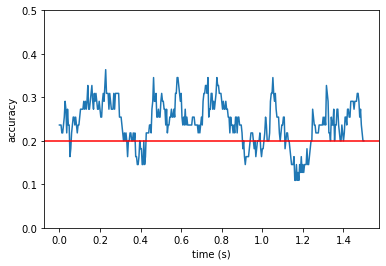

In [201]:
xlabels = np.arange(hw-(0.1*SR), ts-(0.1*SR)-hw)/SR
plt.plot(xlabels, accuracies)
plt.axhline(y=0.2, color='r', linestyle='-')
plt.xlabel('time (s)')
plt.ylabel('accuracy')
plt.ylim([0, 0.5])

In [202]:
avg_acc = []
for i in range(len(accuracies)):
    start = 0 if i-hw<0 else i-hw
    acc = np.mean(np.array([a for a in accuracies[i-start:i+hw]]))
    avg_acc.append(acc)

(0.0, 0.5)

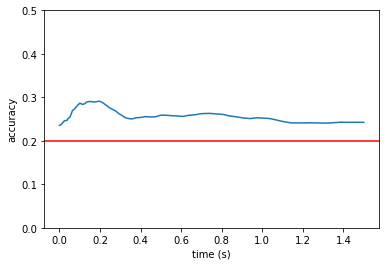

In [203]:
plt.plot(xlabels, avg_acc)
plt.axhline(y=0.2, color='r', linestyle='-')
plt.xlabel('time (s)')
plt.ylabel('accuracy')
plt.ylim([0, 0.5])